<a href="https://colab.research.google.com/github/SeongminCC/CNN_models/blob/main/4_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# modules import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

from torchsummary import summary as summary_

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

  - 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

# 전처리 설정



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])


# 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(testset,
                         batch_size=100,
                         shuffle=True,
                         num_workers=2)

In [ ]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([128, 3, 32, 32])


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

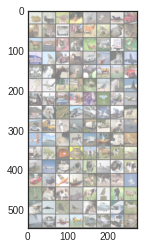

torch.Size([128, 3, 32, 32])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, lables = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)

# 신경망 구성

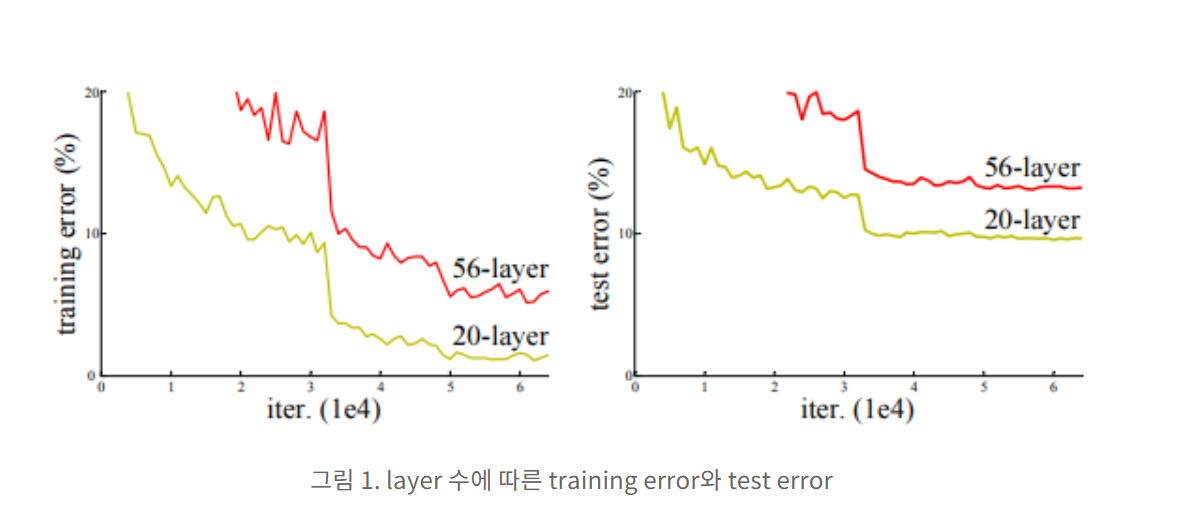

- 지금까지의 CNN모델들은 layer수가 많아지면 많아질 수록 오히려 error가 커지는 현상이 발생했다.
  - 이는 **Vanishing / Exploding gradient현상** 에 의한 결과이다.
- 10 layer 정도의 크기까지는 normalization, Batch normalization과 같은 기법들의 사용으로 문제를 막을 수 있었다.
- 하지만 10 layer이 넘어가는 심층 신경망의 경우, degradation문제가 발생하였다.
    - 이는 네트워크의 깊이가 깊어 짐에 따라 정확도가 포화하고, 급속하게 감소하는 것을 의미한다.

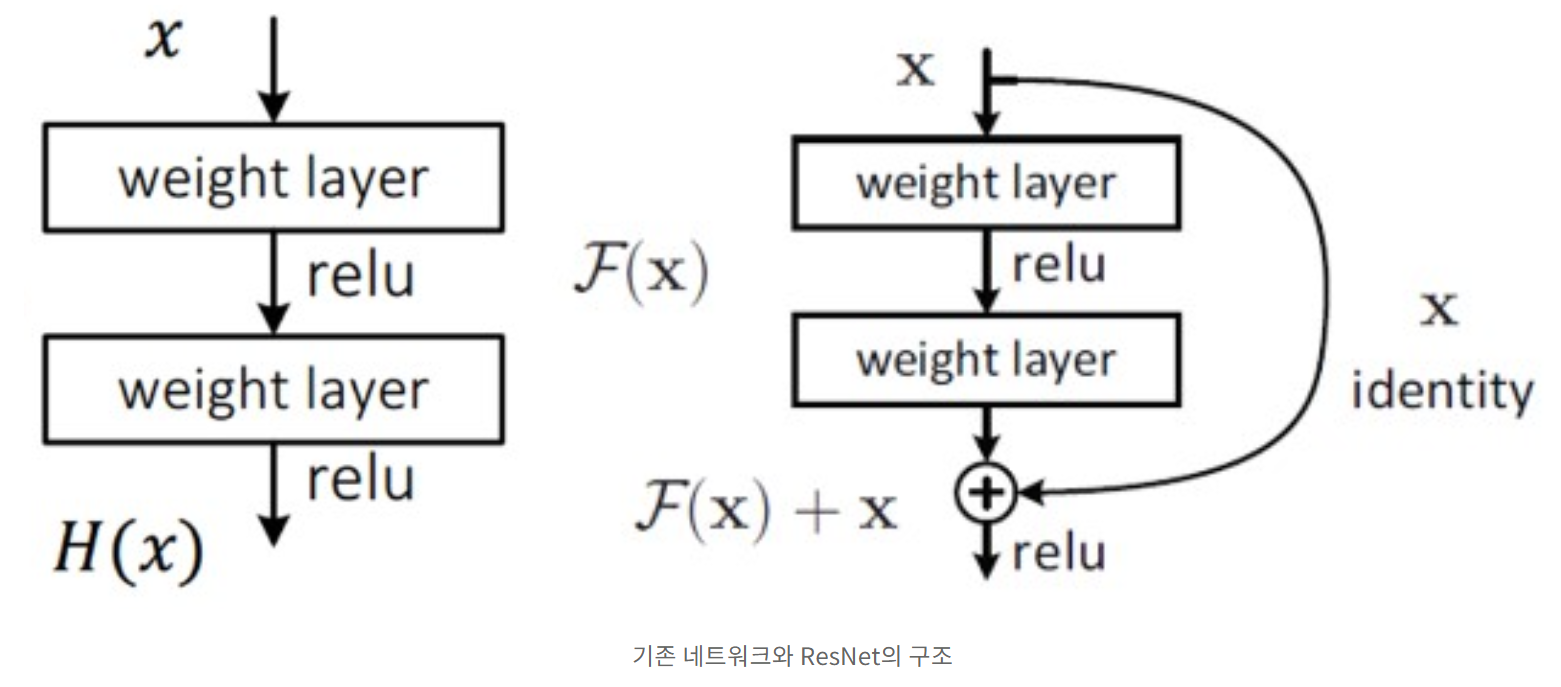

**이를 해결하기 위해 ResNet에서 사용한 것이 Residual Learning이다.**
- 기존 네트워크는 입력 x를 받고 layer를 거쳐 H(x)를 출력하였다.
    - 입력값 x를 타겟값 y로 mapping하는 함수 H(x)를 얻는 것이 목적
- Residual Learning은 H(x)가 아닌 **"출력과 입력의 차인 H(x) - x 를 얻도록 목표를 수정"**한다.
    - 즉 F(x) = H(x) - x를 최소화 시켜야 하는 것이기 때문에 출력과 입력의 차를 줄인다는 의미가 된다.
    - x는 바꾸지 못하는 입력값이므로 F(x)가 0이 되는 것이 최적의 해이다.

    즉 0 = H(x) - x로 H(x) = x 가 된다. -> H(x)를 x로 mapping하는 것이 학습의 목표


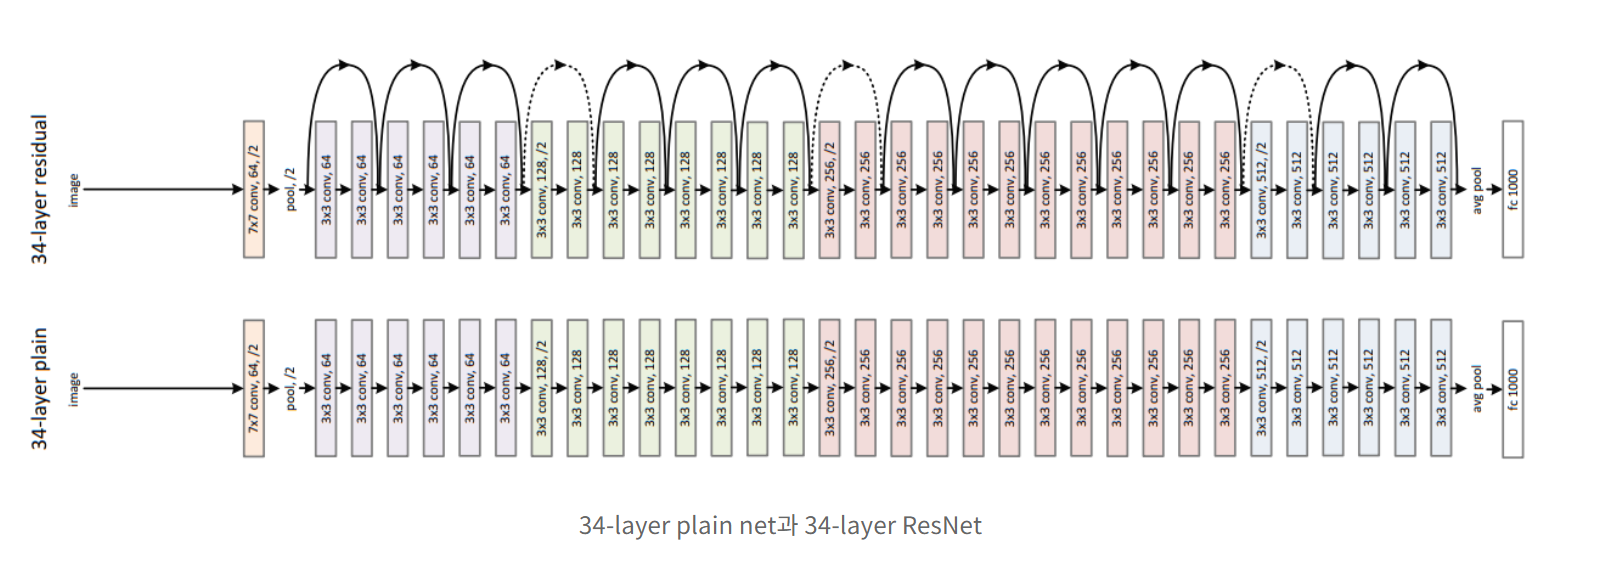

- 34 layer를 가지는 두 모델, plain net, ResNet 모두 구조는 거의 비슷함을 확인할 수 있다.
- 기본구조에서 shortcut하는 부분만 변하였다.

**ResNet모델의 구성**
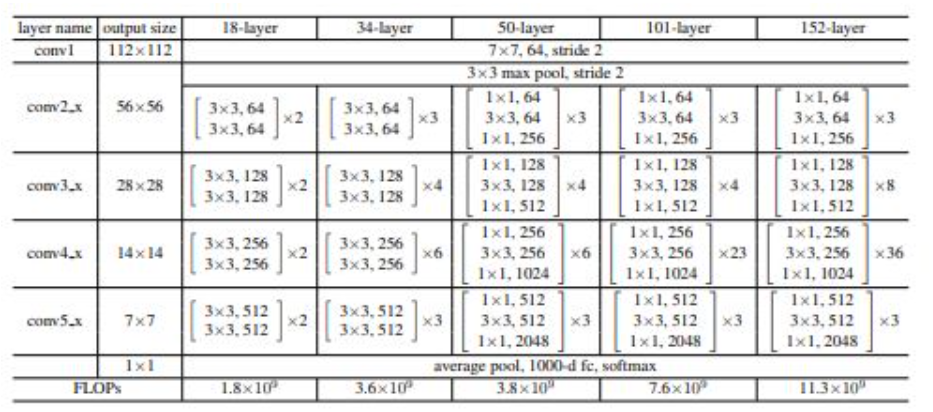

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)  # (x - kernel_size + 2*padding)) / stride + 1 = x  :  size를 같게 해주기 위해 padding을 1로 한다.
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

        if stride != 1:  # stride가 1이 아니라는 것은 input과 output 채널의 개수가 달라짐을 의미한다.
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), # 고로 identity x 의 채널의 개수를 output과 맞춰주기 위해 convolution 층을 이용한다.
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # F(x) + x
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)  # kernel_size : 7 x 7 -> 3 x 3 (CIFAR-10 이미지 크기가 작기 때문)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)  # 사용하는 데이터의 종류가 변해도 보통 채널의 깊이는 바꾸지 않고 그대로 둔다.
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # 처음 stride를 제외하고 나머지 층들의 stride는 1로 통일한다.
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes  # planes 갱신
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # out = F.max_pool2d(out, kernel_size=3, stride=2) # F.max_pool2d 추가 (논문에서 MaxPooling 사용) 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)  # GoogLeNet에서 사용했던 Global Average Pooling(GAP) 를 사용하여 연산을 줄인다.
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

net = ResNet18().to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

# 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

In [ ]:
file_name = 'ResNet_cifar10.pth'

In [ ]:
def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        current_correct = (predicted == labels).sum().item()
        correct += current_correct

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', current_correct / labels.size(0))
            print('Current batch average train loss:', loss.item() / labels.size(0))            
            

# 훈련이 모두 끝난 후 정확도 / 솔실함수 값을 출력  
    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)

            outputs = net(inputs)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()

        print('\nTotal average test accuarcy:', correct / total)
        print('Total average test loss:', loss / total)

        state = {
            'net' : net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
        print('Model Saved!')

In [ ]:
import time
import os

# 학습 수(epoch)가 많아지면 learning rate를 점점 줄여 손실함수가 떨어지지 않음을 방지한다.
def adjust_learning_rate(optimizer, epoch):
  lr = 0.1
  if epoch >= 50:
    lr /= 10
  if epoch >= 100:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

start_time = time.time()

for epoch in range(0, 10):
    train(epoch)
    test(epoch)
    print('\tTime elapsed:', time.time()-start_time)


[ Train epoch: 0 ]

Current batch: 0
Current batch average train accuracy: 0.0390625
Current batch average train loss: 0.019627032801508904

Current batch: 100
Current batch average train accuracy: 0.171875
Current batch average train loss: 0.016336534172296524

Current batch: 200
Current batch average train accuracy: 0.359375
Current batch average train loss: 0.013656439259648323

Current batch: 300
Current batch average train accuracy: 0.3203125
Current batch average train loss: 0.014255348592996597

Total average train accuarcy: 0.29934
Total average train loss: 0.016147818071842193

[ Test epoch: 0 ]

Total average test accuarcy: 0.3438
Total average test loss: 0.01860050503015518
Model Saved!
	Time elapsed: 53.01850438117981

[ Train epoch: 1 ]

Current batch: 0
Current batch average train accuracy: 0.4609375
Current batch average train loss: 0.011302007362246513

Current batch: 100
Current batch average train accuracy: 0.4765625
Current batch average train loss: 0.01133923605084

**Test Accuracy : 78.39%**

**Test Loss : 0.00691**

**걸린 시간 : 약 7분**